In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kannada_offensive_train (1).csv', delimiter='\t', names=['sentence','classes','nan'])
train = train.drop(columns=['nan'])
train.head()

,sentence,classes
0,Tik tok alli jagala madtidralla adra baggenu o...,Not_offensive
1,Anyone from kerala here,not-Kannada
2,Movie rerelease madi plss,Not_offensive
3,Amazon prime alli bittidira....yella manele no...,Not_offensive
4,Guru sure news nanu tik tok dawn lod madeda ya...,Not_offensive


In [4]:
val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kannada_offensive_dev.csv', delimiter='\t', names=['sentence','classes','nan'])
val = val.drop(columns=['nan'])
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kannada_offensive_test.csv',delimiter='\t',names=['sentence'])

In [5]:
test.head(4)

,sentence
0,ಜೈ ಮೋರಿ ಜೈ ರೋಗಿ ಇಸ್ಲಾಂ ಸಾಯಿಸಿ ಇದೆ ಇವರ ಗುರಿ
1,Anna nim e vedio nodinu mathe chaina apps use ...
2,Super anna yenu thappila yela sari agi hellidi...
3,Super sir super super super super


In [6]:
train.count()

sentence    6217
classes     6217
dtype: int64

In [8]:
train['classes'].apply(len).max()

36

In [9]:
train['sentence'].apply(len).max()

732

In [10]:
set(train['classes']) 

{'Not_offensive',
 'Offensive_Targeted_Insult_Group',
 'Offensive_Targeted_Insult_Individual',
 'Offensive_Targeted_Insult_Other',
 'Offensive_Untargetede',
 'not-Kannada'}

In [11]:
encode_dict = {}

def encode_cat(x):
  if x not in encode_dict.keys():
    encode_dict[x] = len(encode_dict)
  return encode_dict[x]

train['encode_cat'] = train['classes'].apply(lambda x: encode_cat(x))
val['encode_cat'] = val['classes'].apply(lambda x: encode_cat(x))

In [12]:
train.head(9)

,sentence,classes,encode_cat
0,Tik tok alli jagala madtidralla adra baggenu o...,Not_offensive,0
1,Anyone from kerala here,not-Kannada,1
2,Movie rerelease madi plss,Not_offensive,0
3,Amazon prime alli bittidira....yella manele no...,Not_offensive,0
4,Guru sure news nanu tik tok dawn lod madeda ya...,Not_offensive,0
5,ಸುದೀಪ್ ಸರ್ ಅಂಡ್ ದರ್ಶನ್ ಸರ್ ಅವರಿಗೆ ಇರೋ ಫ್ಯಾನ್ಸ್...,Not_offensive,0
6,Ade old same story,Offensive_Targeted_Insult_Group,2
7,Superb rakshit sir sobg superb macking,not-Kannada,1
8,Hai Neel (prithvi) wonderful movie dia,not-Kannada,1


In [13]:
y_train = train['encode_cat']
y_val = val['encode_cat']

In [14]:
def clean(df):
    df['sentence'] = df['sentence'].apply(lambda x: x.lower())
    df['sentence'] = df['sentence'].apply(lambda x: re.sub(r' +', ' ',x))
    df['sentence'] = df['sentence'].apply(lambda x: re.sub("[!@#$+%*:()'-]", ' ',x))
    df['sentence'] = df['sentence'].str.replace('\d+', '')

clean(train)
clean(val)
clean(test)

In [15]:
max_features = 2000
max_len = 512
tokenizer = Tokenizer(num_words=max_features, split=' ')

In [16]:
tokenizer.fit_on_texts(train['sentence'].values)
X_train = tokenizer.texts_to_sequences(train['sentence'].values)
# vocab_size = len(tokenizer.word_index) + 1
X_train = pad_sequences(X_train,padding = 'post', maxlen=max_len)

In [17]:
tokenizer.fit_on_texts(val['sentence'].values)
X_val = tokenizer.texts_to_sequences(val['sentence'].values)
# vocab_size = len(tokenizer.word_index) + 1
X_val = pad_sequences(X_val,padding = 'post', maxlen=max_len)

In [18]:
tokenizer.fit_on_texts(test['sentence'].values)
X_test = tokenizer.texts_to_sequences(test['sentence'].values)
# vocab_size = len(tokenizer.word_index) + 1
X_test = pad_sequences(X_test,padding = 'post', maxlen=max_len)

In [19]:
train['sentence'].apply(len).max()

732

In [20]:
train.describe()

,encode_cat
count,6217.000000
mean,0.893839
std,1.393468
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,5.000000


In [21]:
Y_train = pd.get_dummies(y_train).values
Y_val = pd.get_dummies(y_val).values
print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)
print(X_test.shape)

(6217, 512) (6217, 6)
(777, 512) (777, 6)
(778, 512)


In [22]:
from keras.layers import Layer
from keras.layers import Input
from keras.models import Model
from tensorflow.keras import backend as K

class attention(Layer):
    def __init__(self):
        super(attention,self).__init__()

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [23]:
!wget --header="Host: nlp.stanford.edu" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.100 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: _ga=GA1.2.456156586.1539718115; _gid=GA1.2.491677602.1539718115; _gat=1" --header="Connection: keep-alive" "https://nlp.stanford.edu/data/glove.6B.zip" -O "glove.6B.zip" -c

--2021-01-08 15:37:39--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-01-08 15:37:40--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  2.24MB/s    in 6m 27s  

2021-01-08 15:44:07 (2.13 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [24]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [25]:
 from numpy import array
 from numpy import asarray
 from numpy import zeros

 embeddings_index = dict()

 glove_file = open('glove.6B.100d.txt', encoding="utf8")

 for line in glove_file:
     records = line.split()
     word = records[0]
     vector_dimensions = asarray(records[1:], dtype='float32')
     embeddings_index[word] = vector_dimensions
 glove_file.close()

 print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [26]:
word_index = tokenizer.word_index
print(len(word_index))


num_words = min(max_features, len(word_index)) + 1
print(num_words)

embedding_dim = 100

embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.randn(embedding_dim)

18333
2001


In [27]:
K.clear_session()
from keras.regularizers import l2
from keras.initializers import Constant
embed_dim = 100
lstm_out = 128
# model = Sequential()
inputs = Input(shape=(512,))
x = Embedding(num_words, embed_dim,embeddings_initializer=Constant(embedding_matrix),input_length = X_train.shape[1])(inputs)
att_in = Bidirectional(LSTM(lstm_out,return_sequences=True, dropout=0.2))(x)
att_out = attention()(att_in)
d = Dropout(0.2)(att_out)
outputs = Dense(6, activation='softmax')(d)
model = Model(inputs,outputs)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 512, 100)          200100    
_________________________________________________________________
bidirectional (Bidirectional (None, 512, 256)          234496    
_________________________________________________________________
attention (attention)        (None, 256)               768       
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 1542      
Total params: 436,906
Trainable params: 436,906
Non-trainable params: 0
_______________________________________________________

In [28]:
import numpy as np

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train.encode_cat.values),
                                                  train.encode_cat.values)
class_weights = dict(enumerate(class_weights))

In [29]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

In [30]:
history = model.fit(X_train, Y_train,batch_size = 128, validation_data=(X_val,Y_val), epochs=10, verbose=2)

Epoch 1/10
49/49 - 14s - loss: 1.3087 - accuracy: 0.5602 - val_loss: 1.2716 - val_accuracy: 0.5483
Epoch 2/10
49/49 - 4s - loss: 1.2147 - accuracy: 0.5700 - val_loss: 1.2598 - val_accuracy: 0.5483
Epoch 3/10
49/49 - 4s - loss: 1.1698 - accuracy: 0.5704 - val_loss: 1.2313 - val_accuracy: 0.5521
Epoch 4/10
49/49 - 4s - loss: 1.1053 - accuracy: 0.5768 - val_loss: 1.2144 - val_accuracy: 0.5483
Epoch 5/10
49/49 - 4s - loss: 1.0417 - accuracy: 0.5865 - val_loss: 1.2544 - val_accuracy: 0.5521
Epoch 6/10
49/49 - 5s - loss: 0.9313 - accuracy: 0.6532 - val_loss: 1.4306 - val_accuracy: 0.5328
Epoch 7/10
49/49 - 4s - loss: 0.8652 - accuracy: 0.6894 - val_loss: 1.3132 - val_accuracy: 0.5354
Epoch 8/10
49/49 - 5s - loss: 0.8221 - accuracy: 0.7087 - val_loss: 1.4322 - val_accuracy: 0.5354
Epoch 9/10
49/49 - 5s - loss: 0.7914 - accuracy: 0.7204 - val_loss: 1.3776 - val_accuracy: 0.5457
Epoch 10/10
49/49 - 5s - loss: 0.7538 - accuracy: 0.7320 - val_loss: 1.3581 - val_accuracy: 0.5457


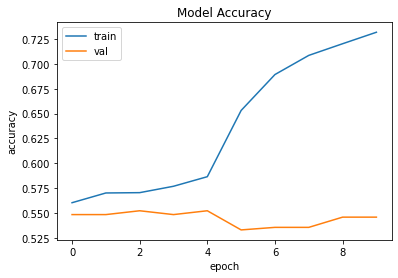

In [31]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'])
#plt.show()
plt.savefig('Model_accuracy.png', dpi=600)

In [32]:
# score = model.evaluate(X_test,verbose=1)
predictions = np.argmax(model.predict(X_test),axis = -1)

# print("val score is {}".format(score[0]))
# print("val Accuracy is {}".format(score[1]))

In [33]:
_, train_acc = model.evaluate(X_train, Y_train, verbose=0)
_, val_acc = model.evaluate(X_val, Y_val, verbose=0)

In [34]:
print(val_acc)
print(train_acc)

0.5456885695457458
0.7593694925308228


In [ ]:
rounded_predictions = np.argmax(model.predict(X_test, batch_size=128, verbose=0),axis = -1)
print(rounded_predictions)

In [36]:
a = {'id':[i for i in range(778)]}
a = pd.DataFrame(a)

df = pd.DataFrame({'id':a.id,'labels':rounded_predictions})
df.labels = df.labels.apply({0:'Not_offensive',5:'Offensive_Untargetede',3:'Offensive_Targeted_Insult_Other',
4:'Offensive_Targeted_Insult_Individual',1:'not-Kannada',2:'Offensive_Targeted_Insult_Group'}.get)
df

,id,labels
0,0,Not_offensive
1,1,Not_offensive
2,2,Not_offensive
3,3,not-Kannada
4,4,Not_offensive
...,...,...
773,773,Not_offensive
774,774,Offensive_Targeted_Insult_Individual
775,775,Not_offensive
776,776,Not_offensive


In [37]:
df.to_csv('LSTM_with_attention_Kannada_submission.csv',index=False)
from google.colab import files
files.download("LSTM_with_attention_Kannada_submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>